<a href="https://colab.research.google.com/github/Sahil01S/Pneumonia_image_clasification_cnn/blob/main/pneumonea_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
uploaded = files.upload()  # This will open a file dialog to select the file




Saving kaggle.json to kaggle.json


In [ ]:
import shutil

# Move kaggle.json to the .kaggle directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')


'/root/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:36<00:00, 157MB/s]
100% 2.29G/2.29G [00:37<00:00, 66.5MB/s]


In [ ]:
import zipfile

# Unzip the downloaded file
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')


In [ ]:
import os

# List all files in the current directory
print("Contents of the current directory:")
print(os.listdir())

# List contents of 'chest_xray'
print("Contents of 'chest_xray':")
print(os.listdir('chest_xray'))

# List the contents of the inner 'chest_xray' directory
print("Contents of 'chest_xray/chest_xray':")
print(os.listdir('chest_xray/chest_xray'))



Contents of the current directory:
['.config', 'chest-xray-pneumonia.zip', 'fer2013.zip', 'chest_xray', 'fer2013', 'sample_data']
Contents of 'chest_xray':
['chest_xray']
Contents of 'chest_xray/chest_xray':
['test', 'val', '__MACOSX', 'chest_xray', 'train']


In [ ]:
# Check the structure of the 'train' and 'test' directories
print("Contents of 'chest_xray/chest_xray/train':")
print(os.listdir('chest_xray/chest_xray/train'))

print("Contents of 'chest_xray/chest_xray/test':")
print(os.listdir('chest_xray/chest_xray/test'))


Contents of 'chest_xray/chest_xray/train':
['PNEUMONIA', 'NORMAL']
Contents of 'chest_xray/chest_xray/test':
['PNEUMONIA', 'NORMAL']


Displaying 3 random NORMAL images:


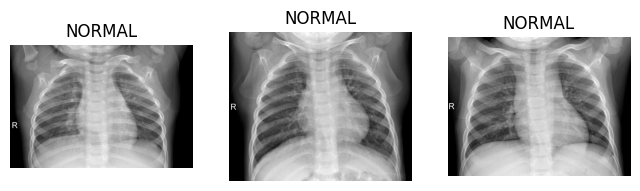

Displaying 3 random PNEUMONIA images:


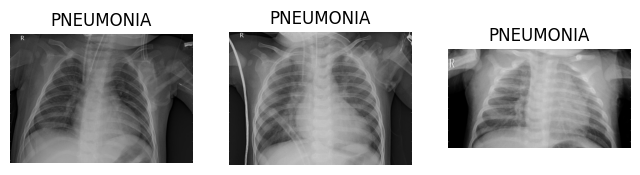

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import random
import os

def visualize_images(data_dir, category, num_images):
    # Get paths for all images in the specified category
    images_path = glob(os.path.join(data_dir, category, '*.jpeg'))

    # Randomly select `num_images` images from the category
    selected_images = random.sample(images_path, num_images)

    plt.figure(figsize=(8,8))
    for i, img_path in enumerate(selected_images):
        plt.subplot(3, 3, i + 1)
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

# Define the directory
train_dir = 'chest_xray/chest_xray/train'

# Visualize 3 random images from each class
print("Displaying 3 random NORMAL images:")
visualize_images(train_dir, 'NORMAL', num_images=3)

print("Displaying 3 random PNEUMONIA images:")
visualize_images(train_dir, 'PNEUMONIA', num_images=3)


In [ ]:
import os

def count_samples(data_dir):
    class_counts = {}

    # List directories in the data_dir (which should be 'NORMAL' and 'PNEUMONIA')
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            num_samples = len(os.listdir(class_dir))
            class_counts[class_name] = num_samples

    return class_counts

# Count samples in each class
class_counts = count_samples(train_dir)
print("Number of samples in each class:")
for class_name, count in class_counts.items():
    print(f'{class_name}: {count}')


Number of samples in each class:
PNEUMONIA: 3875
NORMAL: 1341


as we can see here is a huge data imbalance, we assign class weights to handle imbalance

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight


# Updated directories based on structure
train_dir = 'chest_xray/chest_xray/train'
test_dir = 'chest_xray/chest_xray/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Ensure class_weights is a dictionary with class indices as keys
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

# Fit the model with the correctly formatted class weights
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    class_weight=class_weights_dict # Pass the dictionary here
)

Class weights: {0: 1.9445479962721341, 1: 0.6730645161290323}
Epoch 1/5
131/131 [==============================] - 334s 3s/step - loss: 0.4898 - accuracy: 0.7304 - val_loss: 0.7685 - val_accuracy: 0.6980
Epoch 2/5
131/131 [==============================] - 327s 2s/step - loss: 0.3139 - accuracy: 0.8663 - val_loss: 0.4055 - val_accuracy: 0.8226
Epoch 3/5
131/131 [==============================] - 318s 2s/step - loss: 0.2787 - accuracy: 0.8881 - val_loss: 0.3185 - val_accuracy: 0.8754
Epoch 4/5
131/131 [==============================] - 314s 2s/step - loss: 0.2654 - accuracy: 0.8958 - val_loss: 0.2919 - val_accuracy: 0.8754
Epoch 5/5
131/131 [==============================] - 315s 2s/step - loss: 0.2194 - accuracy: 0.9195 - val_loss: 0.3299 - val_accuracy: 0.8686


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

20/20 [==============================] - 14s 719ms/step - loss: 0.3105 - accuracy: 0.8622
Test Accuracy: 0.8621794581413269


Test accuracy is much good.

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
y_pred_prob = model.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
class_report = classification_report(test_generator.classes, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:")
print(class_report)

20/20 [==============================] - 14s 678ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.40      0.37      0.38       234
   PNEUMONIA       0.64      0.67      0.65       390

    accuracy                           0.55       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.55      0.55       624



The classification report shows that the model performs better at identifying pneumonia (64% precision, 67% recall) compared to normal cases (40% precision, 37% recall). The overall accuracy is 55%, with the weighted averages reflecting a balanced performance across both classes.